## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 8 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75]
redice_lr_patient = [5, 10]

In [8]:
from keras.layers import BatchNormalization
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0723 08:18:32.199732 17496 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:71: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 08:18:32.200715 17496 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:514: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 08:18:32.203695 17496 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4076: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0723 08:18:32.438987 17496 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:130: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 08:18:32.639421 17496 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 08:18:32.644331 17496 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3213: The name tf.log is deprecated. Please use tf.math.log instead.

W0723 08:18:32.738091 17496 deprecation.py:323] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000 [==============================] - 4s 83us/step - loss: 2.2144 - acc: 0.2672 - val_loss: 2.0993 - val_acc: 0.3127
Epoch 2/8
50000/50000 [==============================] - 3s 67us/step - loss: 1.7583 - acc: 0.3849 - val_loss: 1.8261 - val_acc: 0.3696
Epoch 3/8
50000/50000 [==============================] - 3s 67us/step - loss: 1.6303 - acc: 0.4242 - val_loss: 1.6964 - val_acc: 0.4036
Epoch 4/8
50000/50000 [==============================] - 3s 67us/step - loss: 1.5567 - acc: 0.4521 - val_loss: 1.6445 - val_acc: 0.4196
Epoch 5/8
50000/50000 [==============================] - 3s 67us/step - loss: 1.5053 - acc: 0.4726 - val_loss: 1.5971 - val_acc: 0.4344
Epoch 6/8
50000/50000 [==============================] - 3s 67us/step - loss: 1.4629 - acc: 0.4863 - val_loss: 1.5725 - val_acc: 0.4467
Epoch 7/8
50000/50000 [==============================] - 3s 66us/step - loss: 1.4256 - acc: 0.5000 - val_loss: 1.5394 - val_acc: 0.455

50000/50000 [==============================] - 4s 74us/step - loss: 1.4047 - acc: 0.5039 - val_loss: 1.5369 - val_acc: 0.4505
Epoch 4/8
50000/50000 [==============================] - 4s 74us/step - loss: 1.3352 - acc: 0.5279 - val_loss: 1.6151 - val_acc: 0.4246
Epoch 5/8
50000/50000 [==============================] - 4s 73us/step - loss: 1.2707 - acc: 0.5524 - val_loss: 1.5787 - val_acc: 0.4342
Epoch 6/8
50000/50000 [==============================] - 4s 75us/step - loss: 1.2156 - acc: 0.5728 - val_loss: 1.5893 - val_acc: 0.4420
Epoch 7/8
50000/50000 [==============================] - 4s 74us/step - loss: 1.1675 - acc: 0.5889 - val_loss: 1.5590 - val_acc: 0.4467
Epoch 8/8
50000/50000 [==============================] - 4s 73us/step - loss: 1.1181 - acc: 0.6080 - val_loss: 1.4448 - val_acc: 0.4848
Numbers of exp: 7, reduce_factor: 0.75, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp

50000/50000 [==============================] - 4s 72us/step - loss: 1.2253 - acc: 0.5690 - val_loss: 2.2849 - val_acc: 0.3360
Epoch 7/8
50000/50000 [==============================] - 4s 72us/step - loss: 1.1705 - acc: 0.5884 - val_loss: 1.8338 - val_acc: 0.3817
Epoch 8/8
50000/50000 [==============================] - 4s 71us/step - loss: 1.1210 - acc: 0.6040 - val_loss: 1.7266 - val_acc: 0.4113
Numbers of exp: 10, reduce_factor: 0.75, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (

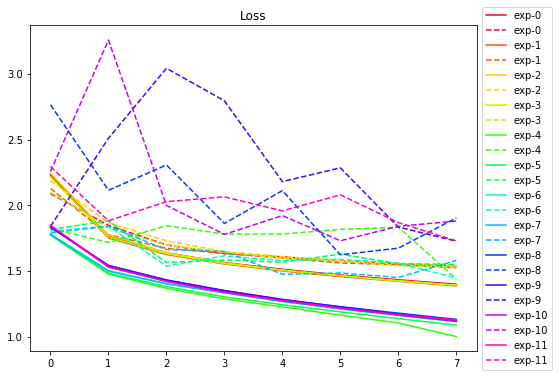

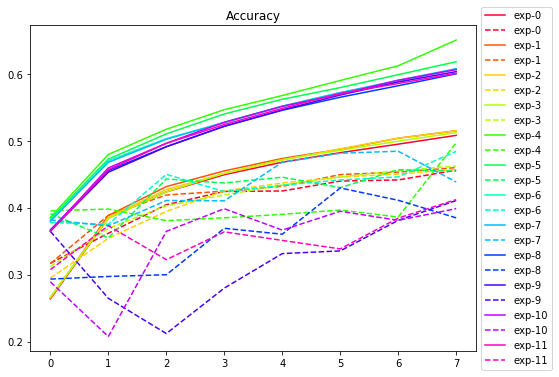

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()